# Problem 1

In [1]:
import numpy, pandas
from sklearn.datasets import make_blobs
import tqdm
from time import sleep
from matplotlib import pyplot


## [1.1 & 1.2] Implementation (binary classification)

The section below is the implementation of the logistic regression model. The model is implemented as the <code>LogisticRegression</code> class.

The loss function implemented is as follows:
$$J(\boldsymbol{w}) = \frac{1}{n} \sum_{i=1}^{n} \ln (1+\exp (-y_i \boldsymbol{w}^\top \boldsymbol{x}_i)) + \lambda \boldsymbol{w}^\top \boldsymbol{w}$$
where $n$ is the batch size, $y_i$ is the labels, $\boldsymbol{x_i}$ is the input features, $\boldsymbol{w}$ is the model weights, and $\lambda$ is the regularization rate. Thus, the model accepts $-1$ and $1$ as the labels.

### [1.1] SGD
The model weight update is performed at the end of each batch. It is formulated as follows:
    $$\boldsymbol{w}_{t+1} = \boldsymbol{w}_{t} - \text{learning_rate} * (\frac{\partial}{\partial \boldsymbol{w}} J(\boldsymbol{w}))$$

$$\frac{\partial}{\partial \boldsymbol{w}}J(\boldsymbol{w}) = \frac{1}{n} \sum_{i=1}^{n} \frac{-y_i \boldsymbol{x}_i \exp (-y_i \boldsymbol{w}^\top \boldsymbol{x}_i)}{1+\exp (-y_i \boldsymbol{w}^\top \boldsymbol{x}_i)} + 2 \lambda \boldsymbol{w} = \frac{1}{n} \sum_{i=1}^{n} (1 - \sigma(y_i \boldsymbol{w}^\top \boldsymbol{x}_i)) (-y_i \boldsymbol{x}_i) + 2 \lambda \boldsymbol{w}$$

### [1.2] Newton
The model weight update is performed at the end of each batch. It is formulated as follows:
    $$\boldsymbol{w}_{t+1} = \boldsymbol{w}_{t} - \text{learning_rate} * \left(\nabla^2 J(\boldsymbol{w})\right)^{-1} (\frac{\partial}{\partial \boldsymbol{w}} J(\boldsymbol{w}))$$

$$\nabla^2 J(\boldsymbol{w}) = \frac{1}{n} \sum_{i=1}^{n} \frac{y_{i}^{2}  \exp (-y_i \boldsymbol{w}^\top \boldsymbol{x}_i)}{(1+\exp (-y_i \boldsymbol{w}^\top \boldsymbol{x}_i))^2} \boldsymbol{x}_i\boldsymbol{x}_i^\top + 2 \lambda \boldsymbol{I} = \frac{1}{n} \sum_{i=1}^{n} (\sigma(y_i \boldsymbol{w}^\top \boldsymbol{x}_i) \space (1 - \sigma(y_i \boldsymbol{w}^\top \boldsymbol{x}_i) \space \boldsymbol{x}_i\boldsymbol{x}_i^\top) + 2 \lambda \boldsymbol{I}$$

### Sigmoid function ($\sigma$)
The sigmoid function is implemented as <code>sigmoid(X)</code>. It accepts a list as the input and outputs a list of sigmoids for all input elements.

In [2]:
def sigmoid(X):
    output = []
    for x_i in X:
        output.append(1 / (1 + numpy.exp(-x_i)))
    return output

class LogisticRegression:
    def __init__(self, lr=0.0001, lambda_weight= 0.0001, n_epochs=1000, 
                 batch_size=1, print_progress_bar=True, learner='sgd'):
        self.weights = None
        self.regularization_weight = lambda_weight
        self.learning_rate = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.__progress_bar = print_progress_bar
        self.__loss_history = []
        self.__learner = learner # {sgd, newton}
        self.__input_dim = 0

    def fit(self, inputs, labels):
        # weight initialization
        self.__input_dim = len(inputs[0])
        self.weights = numpy.zeros((self.__input_dim))
        identity_mat = None
        if self.__learner == 'newton':
            identity_mat = numpy.identity(self.__input_dim)
        num_of_instances = len(inputs)
        
        for it in range(self.n_epochs):
            it_loss = 0
            if self.__progress_bar:
                tbatches = tqdm.trange(num_of_instances // self.batch_size)
            else:
                tbatches = range(num_of_instances // self.batch_size)
            
            running_loss = 0
            for batch_it in tbatches:
                if self.__progress_bar:
                    tbatches.set_description('Epoch ' + str(it))

                # calculate gradient of loss
                dloss = numpy.zeros(self.__input_dim)
                if self.__learner == 'newton':
                    ddloss = numpy.zeros((self.__input_dim, self.__input_dim))

                loss = 0
                for idx in range(self.batch_size):
                    data_idx = (batch_it * self.batch_size) + idx
                    w_x = numpy.inner(self.weights, inputs[data_idx])
                    z = labels[data_idx] * w_x
                    p = sigmoid([z])[0]
                    
                    dloss = numpy.add(dloss, 
                                      (1 - p) * \
                                      (-1 * labels[data_idx] * numpy.asarray(inputs[data_idx])))
                    if self.__learner == 'newton':
                        x_x = numpy.outer(inputs[data_idx], inputs[data_idx])
                        ddloss = numpy.add(ddloss, p * (1 - p) * x_x)
                    loss += (-1 * numpy.log(sigmoid([z])[0]))
                    
                dloss = numpy.add((dloss / self.batch_size), 
                                   2 * self.regularization_weight * numpy.asarray(self.weights))
                if self.__learner == 'newton':
                    ddloss = numpy.add((ddloss / self.batch_size),
                                        2 * self.regularization_weight * identity_mat)
                it_loss += loss

                if self.__progress_bar:
                    if batch_it % (len(tbatches)//5) == 0:
                        tbatches.set_postfix(loss=running_loss / (batch_it + 1))
                
                # weight update
                if self.__learner == 'sgd':
                    self.weights = numpy.subtract(self.weights, 
                                                  self.learning_rate * dloss)
                else:
                    self.weights = numpy.subtract(self.weights,
                                                  self.learning_rate * numpy.matmul(numpy.linalg.inv(ddloss), dloss))

            self.__loss_history.append((it_loss + \
                                        self.regularization_weight * \
                                        numpy.inner(self.weights, self.weights)) / num_of_instances)

    def predict(self, inputs):
        if self.weights is None: # init weight if it's not initialized
            self.__input_dim = len(inputs[0])
            self.weights = numpy.zeros((self.__input_dim))

        preds = []
        for idx in range(len(inputs)):
            z = numpy.inner(self.weights, inputs[idx])
            pred = 1 if sigmoid([z])[0] > 0.5 else -1
            preds.append(pred)
        return preds
    
    def calculate_metrics(self, inputs, labels): 
        # print confusion matrix and accuracy
        confusion_matrix = [[0, 0], [0, 0]] # row: label, col: pred
        preds = self.predict(inputs)
        num_of_instances = len(preds)
        for idx in range(num_of_instances):
            confusion_matrix[0 if labels[idx] == -1 else 1][0 if preds[idx] == -1 else 1] += 1
        
        accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / num_of_instances
        print('Accuracy: %.3f' % accuracy)
        print('Confusion matrix:')
        print(confusion_matrix[0])
        print(confusion_matrix[1])
        
    def get_loss_history(self):
        return self.__loss_history


## [1.4] Implementation (multiclass classification)

The section below is the implementation of the multiclass logistic regression model. The model is implemented as the <code>LogisticRegressionMulticlass</code> class.

We use <b>softmax</b> to perform classification:
$$ \text{p}(y | \boldsymbol{x}) = \text{softmax}(\boldsymbol{w}_y^\top \boldsymbol x) = \frac{\exp(\boldsymbol{w}_y^\top \boldsymbol x)}{\sum_{c=1}^{C} \exp(\boldsymbol{w}_c^\top \boldsymbol x)} $$

$$ \hat{y} = \text{argmax}_y \space \text{p} (y | \boldsymbol{x}) = \text{argmax}_y \space \boldsymbol{w}_y^\top \boldsymbol{x} $$

The log loss of multiclass logistic regression (with L2 regularization) is defined as follows:

$$ J(\boldsymbol{w}_y) = - \ln \text{p} (y | \boldsymbol{x}) = -\boldsymbol{w}_y^\top \boldsymbol{x} + \ln \left( \sum_{c=1}^{C} \exp(\boldsymbol{w}_c^\top \boldsymbol x) \right) + \lambda \boldsymbol{w}^\top \boldsymbol{w}$$


### SGD
The model weight update is performed at the end of each batch. It is formulated as follows:
    $$\boldsymbol{w}^{(t+1)}_y = \boldsymbol{w}^{(t)}_y - \text{learning_rate} * (\frac{\partial}{\partial \boldsymbol{w}_y} J(\boldsymbol{w}^{(t)}_y))$$

For each instance, the gradient is computed as follows:
$$\frac{\partial}{\partial \boldsymbol{w}_y}J(\boldsymbol{w}_k) = \frac{1}{n} \sum_{i=1}^n \left(- \boldsymbol{x}_i * \boldsymbol{I}_{[k_i = y]}+ \frac{\exp(\boldsymbol{w}_y^\top \boldsymbol{x}_i)}{\sum_{c=1}^{C} \exp(\boldsymbol{w}_c^\top \boldsymbol{x}_i)} \boldsymbol{x}_i \right) + 2 \lambda \boldsymbol{w}_y = \frac{1}{n} \sum_{i=1}^n \left( - \boldsymbol{x}_i * \boldsymbol{I}_{[k_i = y]} + \text{softmax}(\boldsymbol{w}_y^\top \boldsymbol{x}_i) \boldsymbol{x}_i \right) + 2 \lambda \boldsymbol{w}_y$$

### Newton
The model weight update is performed at the end of each batch. It is formulated as follows:
    $$\boldsymbol{w}_y^{(t+1)} = \boldsymbol{w}_y^{(t)} - \text{learning_rate} * \left( \nabla^2 J(\boldsymbol{w}^{(t)}_y) \right)^{-1} (\frac{\partial}{\partial \boldsymbol{w}_y} J(\boldsymbol{w}_y^{(t)}))$$

For each class:
$$\nabla^2 J(\boldsymbol{w}_k) = \frac{1}{n} \sum_{i=1}^n \space \text{softmax}(\boldsymbol{w}_y^\top \boldsymbol{x}_i) \space ( 1_{[k_i = y]} - \text{softmax}(\boldsymbol{w}_y^\top \boldsymbol{x}_i))\boldsymbol{x}_i \boldsymbol{x}_i^\top + 2 \lambda \boldsymbol{I}$$


In [3]:
def softmax(x, y, weights):
#     print(x.shape, weights[y].shape)
    z_y = numpy.inner(weights[y], x)
    sum_w_x = 0.0
    for c in range(len(weights)):
        sum_w_x += numpy.exp(numpy.inner(weights[c], x))
    
    return numpy.exp(z_y) / sum_w_x
        

class LogisticRegressionMulticlass:
    def __init__(self, lr=0.0001, lambda_weight= 0.0001, n_epochs=1000, 
                 batch_size=1, print_progress_bar=True, learner='sgd', n_class=3):
        self.weights = None
        self.regularization_weight = lambda_weight
        self.learning_rate = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.n_class = n_class
        self.__progress_bar = print_progress_bar
        self.__loss_history = []
        self.__learner = learner # {sgd, newton}
        self.__input_dim = 0

    def fit(self, inputs, labels):
        # weight initialization
        self.__input_dim = len(inputs[0])
        self.weights = numpy.zeros((self.n_class, self.__input_dim))
        identity_mat = None
        if self.__learner == 'newton':
            identity_mat = numpy.identity(self.__input_dim)
        num_of_instances = len(inputs)
       
        for it in range(self.n_epochs):
            it_loss = 0
            if self.__progress_bar:
                tbatches = tqdm.trange(num_of_instances // self.batch_size)
            else:
                tbatches = range(num_of_instances // self.batch_size)
            
            for batch_it in tbatches:
                if self.__progress_bar:
                    tbatches.set_description('Epoch ' + str(it))

                # calculate gradient of loss
                dloss = numpy.zeros((self.n_class, self.__input_dim))
                if self.__learner == 'newton':
                    ddloss = numpy.zeros((self.n_class, self.__input_dim, self.__input_dim))

                loss = 0
                for idx in range(self.batch_size):
                    data_idx = (batch_it * self.batch_size) + idx
                    
                    s = softmax(inputs[data_idx], labels[data_idx], self.weights)
                    s_x = s * numpy.asarray(inputs[data_idx])
                    
                    for c in range(self.n_class):
                        if c == labels[data_idx]:
                            dloss[c] = numpy.add(dloss[c], numpy.add(-1 * numpy.asarray(inputs[data_idx]), s_x))
                        else:
                            dloss[c] = numpy.add(dloss[c], s_x)
                            
                        if self.__learner == 'newton':
                            ddloss[c] = numpy.add(ddloss[c], s * (1 - s) * numpy.outer(inputs[data_idx],inputs[data_idx]))

                    loss += (-1 * numpy.log(s))
                dloss = numpy.add((dloss / self.batch_size), 
                                 2 * self.regularization_weight * numpy.asarray(self.weights))
                
                if self.__learner == 'newton':
                    ddloss = (ddloss / self.batch_size)
                    for c in range(self.n_class):
                        ddloss[c] = numpy.add(ddloss[c],
                                        2 * self.regularization_weight * identity_mat)
                it_loss += loss
                
                # weight update
                if self.__learner == 'sgd':
                    self.weights = numpy.subtract(self.weights, self.learning_rate * dloss)
                else:
                    for c in range(self.n_class):
                        self.weights[c] = numpy.subtract(self.weights[c], 
                                                      self.learning_rate * numpy.matmul(numpy.linalg.inv(ddloss[c]), dloss[c]))
                
            self.__loss_history.append(it_loss / num_of_instances)

    def predict(self, inputs):
        if self.weights is None: # init weight if it's not initialized
            self.__input_dim = len(inputs[0])
            self.weights = numpy.zeros((self.n_class, self.__input_dim))

        preds = []
        for idx in range(len(inputs)):
            w_x = []
            sum_w_x = 0.0
            max_prob = -1.0
            for c in range(self.n_class):
                z = numpy.exp(numpy.inner(self.weights[c], inputs[idx]))
                w_x.append(z)
                sum_w_x += z
                
            pred = 0
            for c in range(self.n_class):
                prob = w_x[c] / sum_w_x
                if prob > max_prob:
                    max_prob = prob
                    pred = c

            preds.append(pred)
        return preds
    
    def calculate_metrics(self, inputs, labels):
        # print confusion matrix and accuracy
        confusion_matrix = [[0 for _ in range(self.n_class)] for _ in range(self.n_class)] # row: label, col: pred
        preds = self.predict(inputs)
        num_of_instances = len(preds)
        
        for idx in range(num_of_instances):
            confusion_matrix[labels[idx]][preds[idx]] += 1        
        
        n_correct = 0
        for c in range(self.n_class):
            n_correct += confusion_matrix[c][c]
        
        accuracy = n_correct / num_of_instances
        print('Accuracy: %.3f' % accuracy)
        print('Confusion matrix:')
        for c in range(self.n_class):
            print(confusion_matrix[c])
        
    def get_loss_history(self):
        return self.__loss_history

## Binary Classification Experiement
### Dataset Initialization

In [4]:
# dataset 4
numpy.random.seed(seed=123)
n = 200
x_d4 = 3 * (numpy.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * numpy.random.randn(n)) > 0
y_d4 = 2 * y_d4 -1
print(x_d4[0:5])
print(y_d4[0:5])

[[ 0.58940756 -0.641582   -0.81944564  0.15394431]
 [ 0.65840691 -0.23068062  1.4422926   0.55448922]
 [-0.0572043  -0.32364745 -0.47046595  0.68714912]
 [-0.18428327 -1.32096631 -0.30586723  0.71398622]
 [-0.95252481 -0.97364473  0.09465412  0.09548276]]
[1 1 1 1 1]


### Model initialization & training
#### SGD

In [5]:
model = LogisticRegression(lr=0.0001, lambda_weight= 0.0001, n_epochs=100, 
                 batch_size=1, print_progress_bar=False)

print('Model performance before training')
model.calculate_metrics(x_d4, y_d4)

Model performance before training
Accuracy: 0.440
Confusion matrix:
[88, 0]
[112, 0]


In [6]:
model.fit(x_d4, y_d4)

#### Evaluation

In [7]:
model.calculate_metrics(x_d4, y_d4)

Accuracy: 0.915
Confusion matrix:
[87, 1]
[16, 96]


#### Newton Method

In [8]:
model_newton = LogisticRegression(lr=0.0001, lambda_weight= 0.0001, n_epochs=100, 
                 batch_size=1, print_progress_bar=False, learner='newton')

print('Model performance before training')
model_newton.calculate_metrics(x_d4, y_d4)

Model performance before training
Accuracy: 0.440
Confusion matrix:
[88, 0]
[112, 0]


In [9]:
model_newton.fit(x_d4, y_d4)

#### Evaluation

In [10]:
model_newton.calculate_metrics(x_d4, y_d4)

Accuracy: 0.920
Confusion matrix:
[87, 1]
[15, 97]


### [1.3] SGD vs Newton method $ |J(\boldsymbol{w}) - J(\boldsymbol{\hat{w}})| $

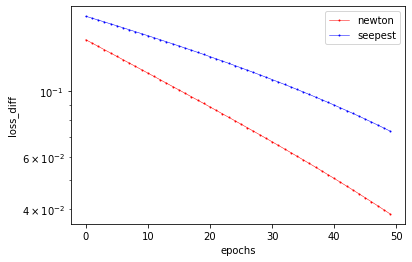

In [11]:
loss_newton_history = model_newton.get_loss_history()
loss_sgd_history = model.get_loss_history()
min_loss_newton = min(loss_newton_history)
min_loss_sgd = min(loss_sgd_history)

pyplot.plot(numpy.abs(loss_newton_history[:50]-min_loss_newton), 'ro-', linewidth=0.5, markersize=1, label='newton')
pyplot.plot(numpy.abs(loss_sgd_history[:50]-min_loss_sgd), 'bo-', linewidth=0.5, markersize=1, label='seepest')
pyplot.legend()
pyplot.yscale('log')
pyplot.ylabel('loss_diff')
pyplot.xlabel('epochs')
pyplot.show()

## [1.4] Multiclass Classification Experiement
### Dataset Initialization

In [12]:
# dataset 5
numpy.random.seed(seed=123)
n = 200
x_d5 = 3 * (numpy.random.rand(n, 4) - 0.5)
W = numpy.array([[ 2,  -1, 0.5,],
              [-3,   2,   1,],
              [ 1,   2,   3]])
y_d5 = numpy.argmax(numpy.dot(numpy.hstack([x_d5[:,:2], numpy.ones((n, 1))]), W.T)
                        + 0.5 * numpy.random.randn(n, 3), axis=1)

print(x_d5[0:5])
print(y_d5[0:5])

[[ 0.58940756 -0.641582   -0.81944564  0.15394431]
 [ 0.65840691 -0.23068062  1.4422926   0.55448922]
 [-0.0572043  -0.32364745 -0.47046595  0.68714912]
 [-0.18428327 -1.32096631 -0.30586723  0.71398622]
 [-0.95252481 -0.97364473  0.09465412  0.09548276]]
[0 2 2 0 1]


### Model initialization & training
#### SGD

In [13]:
model_multi = LogisticRegressionMulticlass(lr=0.0001, lambda_weight= 0.0001, n_epochs=200, 
                 batch_size=1, print_progress_bar=False, learner='sgd', n_class=3)

print('Model performance before training')
model_multi.calculate_metrics(x_d5, y_d5)

Model performance before training
Accuracy: 0.210
Confusion matrix:
[42, 0, 0]
[64, 0, 0]
[94, 0, 0]


In [14]:
model_multi.fit(x_d5, y_d5)

#### Evaluation

In [15]:
model_multi.calculate_metrics(x_d5, y_d5)

Accuracy: 0.805
Confusion matrix:
[40, 1, 1]
[1, 62, 1]
[21, 14, 59]


#### Newton Method

In [16]:
model_multi_newton = LogisticRegressionMulticlass(lr=0.0001, lambda_weight= 0.0001, n_epochs=200, 
                 batch_size=1, print_progress_bar=False, learner='newton', n_class=3)

print('Model performance before training')
model_multi_newton.calculate_metrics(x_d5, y_d5)

Model performance before training
Accuracy: 0.210
Confusion matrix:
[42, 0, 0]
[64, 0, 0]
[94, 0, 0]


In [17]:
model_multi_newton.fit(x_d5, y_d5)

#### Evaluation

In [18]:
model_multi_newton.calculate_metrics(x_d5, y_d5)

Accuracy: 0.815
Confusion matrix:
[41, 0, 1]
[2, 61, 1]
[19, 14, 61]


### SGD vs Newton method $ |J(\boldsymbol{w}) - J(\boldsymbol{\hat{w}})| $

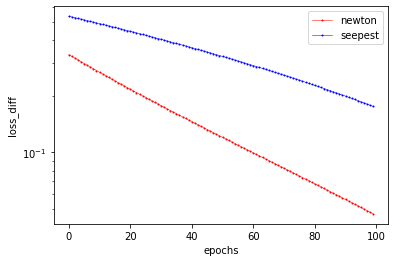

In [19]:
loss_newton_history_multi = model_multi_newton.get_loss_history()
loss_sgd_history_multi = model_multi.get_loss_history()
min_loss_newton_multi = min(loss_newton_history_multi)
min_loss_sgd_multi = min(loss_sgd_history_multi)

pyplot.plot(numpy.abs(loss_newton_history_multi[:100] - min_loss_newton_multi), 'ro-', linewidth=0.5, markersize=1, label='newton')
pyplot.plot(numpy.abs(loss_sgd_history_multi[:100] - min_loss_sgd_multi), 'bo-', linewidth=0.5, markersize=1, label='seepest')
pyplot.legend()
pyplot.yscale('log')
pyplot.ylabel('loss_diff')
pyplot.xlabel('epochs')
pyplot.show()